# Single model pFBA predictions

In [1]:
import reframed
import pandas as pd
import numpy as np

import seaborn as sns

import os
import json

import copy
import functions.general_functions as general_func

#### Load data

In [2]:
all_mags_paper = general_func.read_allmags_data()
all_mags_paper.head(2)

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.1,Compost_Digestate,Xylan,99.37,0.32,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora amygdalina_A,5147597.0,48.0,197896.0,4902.0,CH14-bin.1,54.707294
CH14-bin.2,Compost_Digestate,Xylan,99.37,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Robinsoniella,Robinsoniella peoriensis,5647052.0,70.0,172899.0,4618.0,CH14-bin.2,18.831114


In [3]:
with open("output/relevant_MAGs_99.txt") as text_file:
    relevant_MAGs = text_file.read().split("\n")

relevant_MAGs = [string.replace("\t","") for string in relevant_MAGs]


#### Load models

In [4]:
GEMs_dict = {}

directory = os.fsencode("output/GEMs/GEMs_adapt_media/")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    print(filename)

    GEMs_dict[filename[:-4]]= reframed.load_cbmodel("output/GEMs/GEMs_adapt_media/"+filename)


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

### Define environment

**From SynCon2 to SynCon1**

"SynCon2 had the same composition, but it lacked ascorbic acid, and it had two additional trace elements (selenium and wolfram)"

Add
- Ascorbate: ascb__L

Remove
- Selenite (inorganic selenium): slnt
- (wolfram: not in BiGG database)

In [5]:
syncon2 = pd.read_csv("input/syncon2media_combined.csv",header=None)
syncon2 = list(syncon2[0].values)
syncon1 = copy.copy(syncon2)
syncon1.remove("slnt")
syncon1.append("ascb__L")

In [6]:
substrate_composition = {"Avicel":["cellb","cell3","cell4","cell5"],
                         "PASC":["cellb","cell3","cell4","cell5"],
                         "Xylan":["xylb","xyl3","xylan4","xylan8"]}

In [7]:
syncon1_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon1_environments[substrate_name]= reframed.Environment.from_compounds(syncon1)
    for met in met_mols:
        syncon1_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

In [8]:
syncon2_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon2_environments[substrate_name]= reframed.Environment.from_compounds(syncon2)
    for met in met_mols:
        syncon2_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

### FBA growth predictions - SynCon2 environment above 1%<

In [9]:
community_groups = all_mags_paper.groupby(by= ["Source","Substrate"]).groups

In [10]:
FBA_growth = {}
for community, MAGs in community_groups.items(): 
    FBA_growth[community]={}
    for MAG in MAGs:
        if MAG not in relevant_MAGs:
            continue
            
        print(MAG)
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        sol = reframed.FBA(model)
        
        if sol is None:
            FBA_growth[community][MAG]=None
        else:
            FBA_growth[community][MAG]=sol

CH13-bin.12
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
CH13-bin.11
CH13-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/

CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH3-bin.2
CH3-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH3-bin.0


In [11]:
FBA_growth[('Marshland',
  'Xylan')] #['CH14-bin.1'].show_values(pattern="R_EX",sort=True)

{'CH3-bin.2': Objective: -0.0
 Status: Optimal,
 'CH3-bin.1': Objective: 0.6096824858922801
 Status: Optimal,
 'CH3-bin.0': Objective: 0.8262800511408405
 Status: Optimal}

In [12]:
syncon2_environments["Xylan"]

R_EX_zn2_e	-10.0	inf
R_EX_mn2_e	-10.0	inf
R_EX_fe3_e	-10.0	inf
R_EX_k_e	-10.0	inf
R_EX_b12_e	-10.0	inf
R_EX_slnt_e	-10.0	inf
R_EX_so4_e	-10.0	inf
R_EX_ribflv_e	-10.0	inf
R_EX_cl_e	-10.0	inf
R_EX_nh4_e	-10.0	inf
R_EX_btn_e	-10.0	inf
R_EX_pydxn_e	-10.0	inf
R_EX_ni2_e	-10.0	inf
R_EX_rbflvrd_e	-10.0	inf
R_EX_h2o_e	-10.0	inf
R_EX_pi_e	-10.0	inf
R_EX_fe2_e	-10.0	inf
R_EX_fol_e	-10.0	inf
R_EX_pnto__R_e	-10.0	inf
R_EX_cu2_e	-10.0	inf
R_EX_na1_e	-10.0	inf
R_EX_tungs_e	-10.0	inf
R_EX_mobd_e	-10.0	inf
R_EX_cys__L_e	-10.0	inf
R_EX_mg2_e	-10.0	inf
R_EX_4abz_e	-10.0	inf
R_EX_h_e	-10.0	inf
R_EX_nac_e	-10.0	inf
R_EX_ca2_e	-10.0	inf
R_EX_cobalt2_e	-10.0	inf
R_EX_thm_e	-10.0	inf
R_EX_xylb_e	-10	0
R_EX_xyl3_e	-10	0
R_EX_xylan4_e	-10	0
R_EX_xylan8_e	-10	0

In [13]:
mags_growth = pd.Series({GEM:sol.fobj for GEM_sol_dict in FBA_growth.values() for GEM,sol in GEM_sol_dict.items()})

# Add the source and substrate to this data
growth_community_df = pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],mags_growth],axis=1)

# Change from float to False or positive
growth_community_df.dropna(inplace=True)
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)

# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()

# Change grows index to column
growth_community_grouped_df = growth_community_grouped_df.reset_index(level="Grows")

# Make different columns for grows and does not grow
growth_community_grouped_df = pd.concat([growth_community_grouped_df[growth_community_grouped_df["Grows"]].drop("Grows",axis=1),growth_community_grouped_df[~growth_community_grouped_df["Grows"]].drop("Grows",axis=1)],axis=1)

# Name columns
growth_community_grouped_df.columns = ["# growing","# not growing"]
growth_community_grouped_df.fillna(0,inplace=True)
growth_community_grouped_df["# growing"] = growth_community_grouped_df["# growing"].map(int)
growth_community_grouped_df

# growing  # not growing
Source            Substrate                          
Compost_Digestate Avicel             3              7
                  PASC               9              6
                  Xylan              1              2
Cow_Manure        Avicel             7              6
                  PASC              10              5
                  Xylan              3              3
Marshland         PASC               4              3
                  Xylan              2              1

<Axes: xlabel='Source,Substrate'>

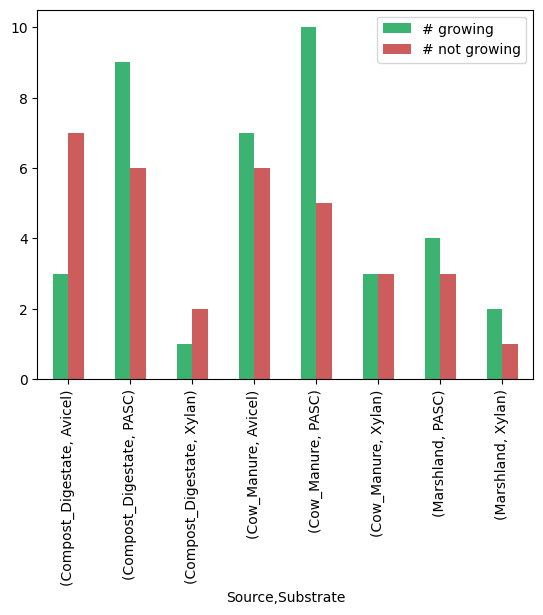

In [14]:
import matplotlib.pyplot as plt

growth_community_grouped_df.plot(kind="bar",color=['mediumseagreen','indianred'])


In [16]:
# Add the source and substrate to this data
all_mags_paper_95 = all_mags_paper[all_mags_paper["new_coverage"]>5]
growth_community_df = pd.concat([all_mags_paper_95.loc[:,["Source","Substrate"]],pd.Series({GEM:sol.fobj for sour_sub,GEM_sol_dict in FBA_growth.items() for GEM,sol in GEM_sol_dict.items()})],axis=1)
# Change from float to False or positive
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)
# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()


# Change grows index to column
growth_community_grouped_df = growth_community_grouped_df.reset_index(level="Grows")

# Make different columns for grows and does not grow
growth_community_grouped_df = pd.concat([growth_community_grouped_df[growth_community_grouped_df["Grows"]].drop("Grows",axis=1),growth_community_grouped_df[~growth_community_grouped_df["Grows"]].drop("Grows",axis=1)],axis=1)

# Name columns
growth_community_grouped_df.columns = ["# growing","# not growing"]

growth_community_grouped_df.fillna(0,inplace=True)
growth_community_grouped_df["# growing"] = growth_community_grouped_df["# growing"].map(int)

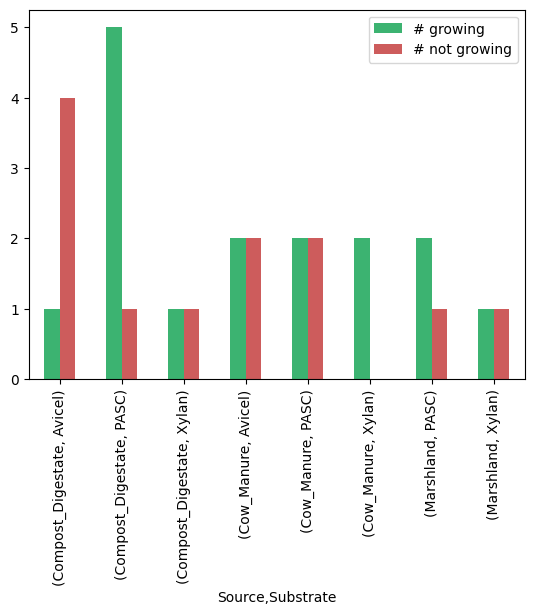

In [17]:
growth_community_grouped_df.plot(kind="bar",color=['mediumseagreen','indianred'])
plt.savefig("grows_count.png",bbox_inches='tight')

**Production**

In [18]:
FBA_production = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]

for community, MAGs in community_groups.items(): 
    FBA_production[community]={}
    
    for MAG in MAGs:
        if MAG not in relevant_MAGs:
            continue
        print(MAG)
            
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        
        FBA_production[community][MAG] = {}
        
        for met in interesting_compounds:
            if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
                FBA_production[community][MAG][met]=None
                continue
            
            sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

            if sol is None:
                FBA_production[community][MAG][met]=None
            else:
                FBA_production[community][MAG][met]=sol.fobj

CH13-bin.12
CH13-bin.11


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_btn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cellb_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')


CH14-bin.2
CH14-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [19]:
pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()

,etoh,lac__L,ac,ppa,but,2mpa,isobuta,ibt,pta,hxa,isocap
CH13-bin.12,NaN,10.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CH13-bin.11,NaN,20.000000,20.000000,11.764706,-0.0,NaN,NaN,NaN,NaN,-0.000000,NaN
CH13-bin.4,NaN,NaN,-0.000000,-0.000000,-0.0,NaN,-0.0,NaN,-0.000000,-0.000000,NaN
CH13-bin.14,NaN,70.000000,70.000000,-0.000000,NaN,NaN,NaN,NaN,70.000000,70.000000,105.250
CH13-bin.25,NaN,NaN,37.777778,48.571429,59.0,NaN,NaN,NaN,NaN,-0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
CH1-bin.1,NaN,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,-0.0,-0.000000,-0.000000,NaN
CH1-bin.10,NaN,-0.000000,-0.000000,NaN,-0.0,NaN,NaN,NaN,-0.000000,-0.000000,NaN
CH3-bin.2,182.694656,50.000000,50.000000,NaN,50.0,NaN,122.8,50.0,NaN,-0.000000,NaN
CH3-bin.1,NaN,47.893639,36.666667,41.803279,NaN,NaN,NaN,NaN,45.348837,41.417910,NaN


In [20]:
# Add the source and substrate to this data
prod_sour_sub_df= pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()],axis=1)

prod_sour_sub_df.fillna(0,inplace=True)

In [21]:
# Change from floats to binary
prod_sour_sub_df_bools =  prod_sour_sub_df.iloc[:,:2]

prod_sour_sub_df_bools = pd.concat([prod_sour_sub_df_bools,prod_sour_sub_df.iloc[:,2:].map(lambda x:x>1e-6)],axis=1)

prod_sour_sub_df_bools

,Source,Substrate,etoh,lac__L,ac,ppa,but,2mpa,isobuta,ibt,pta,hxa,isocap
CH14-bin.1,Compost_Digestate,Xylan,False,False,True,True,True,True,False,False,False,False,True
CH14-bin.2,Compost_Digestate,Xylan,False,False,True,True,False,False,False,False,False,False,False
CH14-bin.4,Compost_Digestate,Xylan,False,False,False,False,False,False,False,False,False,False,False
CH9-bin.0,Cow_Manure,Xylan,False,False,True,False,False,False,False,True,False,False,False
CH9-bin.6,Cow_Manure,Xylan,False,False,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH8-bin.11,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH13-bin.16,Compost_Digestate,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH8-bin.27,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH8-bin.20,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False


In [22]:
# Group by source and substrate
prod_sour_sub_grouped_df = prod_sour_sub_df_bools.groupby(["etoh"]).value_counts()

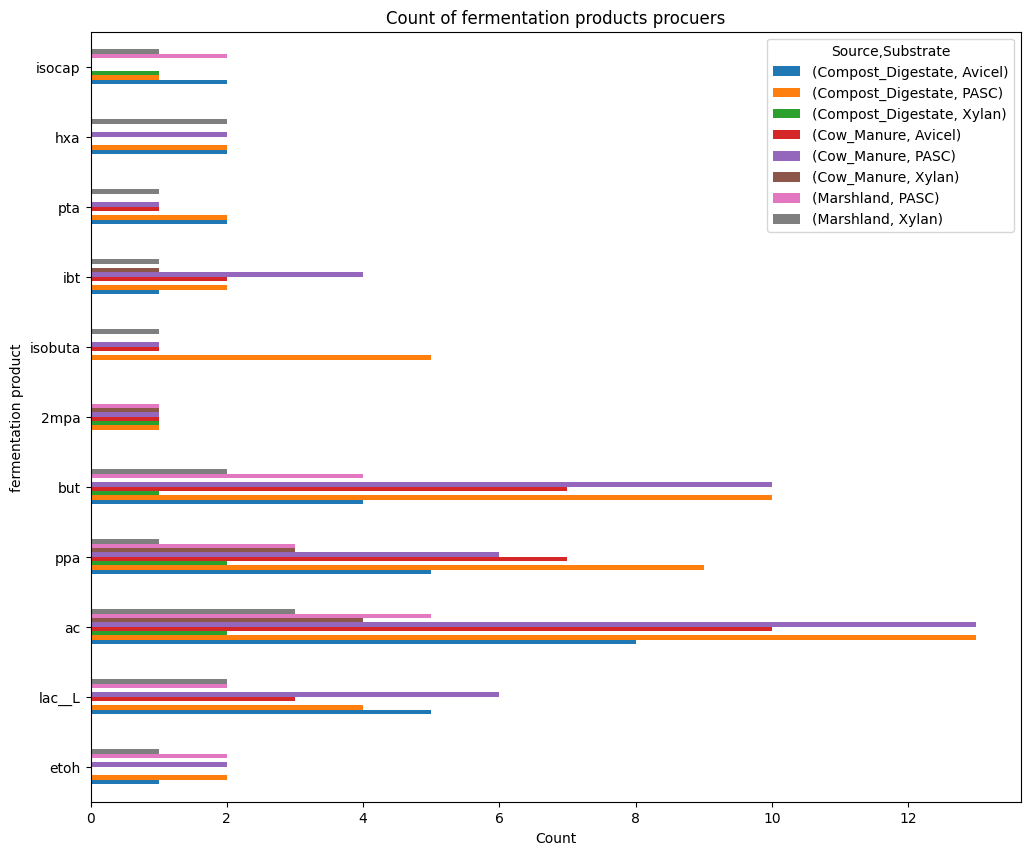

In [23]:
prod_sour_sub_df_bools.groupby(["Source","Substrate"]).sum().transpose().plot(kind="barh",figsize=(12,10))
plt.xlabel("Count")
plt.ylabel("fermentation product")
plt.title("Count of fermentation products procuers")
plt.show()

#### Fermentation product by phyla

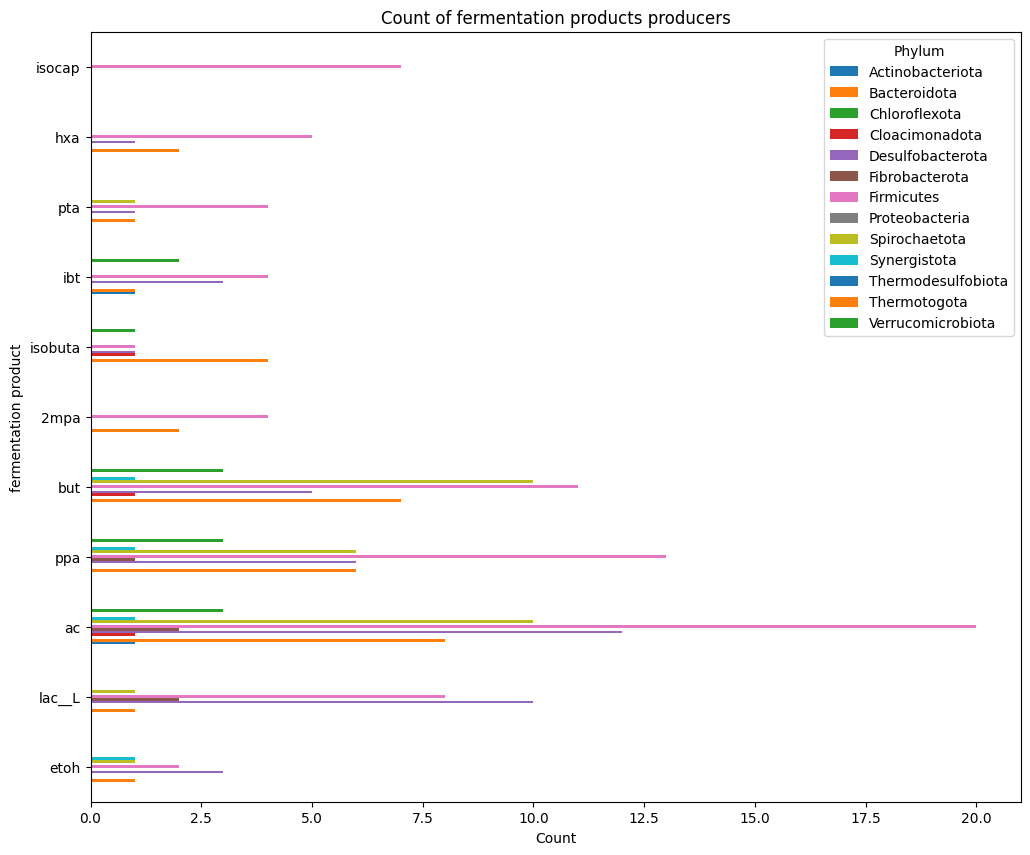

In [24]:
prod_phyla_df_bools = pd.concat([all_mags_paper["Phylum"],prod_sour_sub_df_bools],axis=1)

prod_phyla_df_bools = prod_phyla_df_bools.drop(["Substrate","Source"],axis=1)

prod_phyla_df_bools.groupby("Phylum").sum().transpose().plot(kind="barh",figsize=(12,10))
plt.xlabel("Count")
plt.ylabel("fermentation product")
plt.title("Count of fermentation products producers")
plt.show()

#### Production in complete media

In [25]:
FBA_production_complete = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]


for MAG,model in GEMs_dict.items(): 
    print(MAG)
    FBA_production_complete[MAG]={}
        
    model = GEMs_dict[MAG]
    reframed.Environment.complete(model=model,inplace=True)
    
    for met in interesting_compounds:
        if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
            FBA_production_complete[MAG][met]=None
            continue

        sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

        if sol is None:
            FBA_production_complete[MAG][met]=None
        else:
            FBA_production_complete[MAG][met]=sol.fobj

CH7-bin.18
CH15-bin.7
CH13-bin.0
CH1-bin.4
CH13-bin.1
CH13-bin.11
CH15-bin.6
CH7-bin.2
CH13-bin.13
CH1-bin.10
CH1-bin.6
CH13-bin.2
CH13-bin.12
CH15-bin.5
CH7-bin.1
CH15-bin.1
CH1-bin.3
CH13-bin.17
CH15-bin.0
CH7-bin.4
CH7-bin.23
CH7-bin.6
CH15-bin.22
CH15-bin.2
CH1-bin.1
CH13-bin.4
CH13-bin.14
CH15-bin.23
CH7-bin.20
CH8-bin.8
CH8-bin.9
CH8-bin.25
CH14-bin.4
CH14-bin.1
CH8-bin.21
CH14-bin.2
CH8-bin.22
CH8-bin.2
CH8-bin.29
CH8-bin.7
CH8-bin.6
CH3-bin.2
CH8-bin.14
CH8-bin.16
CH3-bin.0
CH8-bin.5
CH3-bin.1
CH8-bin.17
CH7-bin.11
CH9-bin.1
CH15-bin.12
CH13-bin.25
CH15-bin.13
CH9-bin.0
CH7-bin.12
CH9-bin.2
CH7-bin.9
CH15-bin.10
CH7-bin.8
CH7-bin.13
CH7-bin.17
CH15-bin.8
CH15-bin.15
CH7-bin.16
CH9-bin.6
CH9-bin.4
CH15-bin.17
CH1-bin.8
CH1-bin.9
CH15-bin.16
CH7-bin.15
CH9-bin.5


In [26]:
prod_complete = pd.DataFrame(FBA_production_complete)
prod_complete

,CH7-bin.18,CH15-bin.7,CH13-bin.0,CH1-bin.4,CH13-bin.1,CH13-bin.11,CH15-bin.6,CH7-bin.2,CH13-bin.13,CH1-bin.10,...,CH15-bin.15,CH7-bin.16,CH9-bin.6,CH9-bin.4,CH15-bin.17,CH1-bin.8,CH1-bin.9,CH15-bin.16,CH7-bin.15,CH9-bin.5
etoh,NaN,NaN,NaN,NaN,NaN,NaN,989.620905,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,702.578231,NaN,NaN,NaN
lac__L,333.889252,NaN,624.810127,NaN,742.440863,780.893701,400.925926,NaN,NaN,430.022901,...,527.202944,538.036925,NaN,NaN,831.315050,NaN,645.388889,3013.508439,374.230769,10.000000
ac,337.987735,857.773438,925.500000,709.843750,917.500000,752.508865,1090.944700,490.000000,797.361111,294.257991,...,429.596774,355.031563,865.000000,705.284553,991.264368,1843.583333,682.236842,2183.590426,553.471074,1531.721490
ppa,NaN,-0.000000,458.714286,NaN,NaN,426.366782,495.844347,540.000000,765.694444,NaN,...,561.153846,30.000000,378.712121,NaN,497.552602,1452.121212,221.475410,2671.875000,-0.000000,1312.270833
but,NaN,910.000000,755.433333,838.386364,NaN,10.000000,NaN,347.536232,1153.541667,134.481841,...,622.627919,NaN,NaN,10.000000,NaN,1301.714286,557.756410,2236.060606,620.000000,NaN
2mpa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,595.000000,NaN,NaN,NaN,1931.992754,NaN,707.500000
isobuta,NaN,NaN,NaN,NaN,730.562914,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,742.954261,NaN,NaN,NaN,NaN,NaN
ibt,NaN,NaN,766.988889,NaN,NaN,NaN,NaN,490.000000,NaN,NaN,...,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pta,256.879793,NaN,432.787475,NaN,-0.000000,NaN,NaN,NaN,NaN,488.228942,...,-0.000000,-0.000000,NaN,-0.000000,NaN,-0.000000,-0.000000,NaN,NaN,NaN
hxa,342.653480,10.000000,470.423417,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,10.000000,...,20.000000,-0.000000,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,10.000000,-0.000000
